In [1]:
%matplotlib inline
import sys
sys.path.append('../../trajectron')
import os
import numpy as np
import torch
import dill
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from helper import *
import visualization

In [2]:
import scipy
print('scipy version:', scipy.__version__)

scipy version: 1.3.0


## Load nuScenes SDK and data

In [3]:
nuScenes_data_path = '/home/wonder/datasets/nuscenes/mini' 
nuScenes_devkit_path = './devkit/python-sdk/'
sys.path.append(nuScenes_devkit_path)
from nuscenes.map_expansion.map_api import NuScenesMap
nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name='boston-seaport')

In [4]:
line_colors = ['#375397','#80CBE5','#ABCB51','#F05F78', '#C8B0B0']

# Map Encoding Demo

In [5]:
with open('../processed/nuScenes_test_mini_full.pkl', 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes

In [8]:
ph = 6
log_dir = '/home/wonder/alt-traj/Trajectron-plus-plus/experiments/nuScenes/models'

In [9]:
model_dir = os.path.join(log_dir, 'models_09_Jul_2025_12_21_35_int_ee_me') 
eval_stg, hyp = load_model(model_dir, eval_env, ts=9)


Loading from /home/wonder/alt-traj/Trajectron-plus-plus/experiments/nuScenes/models/models_09_Jul_2025_12_21_35_int_ee_me/model_registrar-9.pt
Loaded!



In [10]:
eval_scenes

[Scene: Duration: 19.5s, Nodes: 60, Map: Yes.,
 Scene: Duration: 20.0s, Nodes: 27, Map: Yes.]

In [11]:
scene = eval_scenes[0]
scene.name

'103'

In [12]:
# Define ROI in nuScenes Map
x_min=530.0
x_max=760.0
y_min=1523.0
y_max=1732.0

In [13]:
layers = ['drivable_area',
          'road_segment',
          'lane',
          'ped_crossing',
          'walkway',
          'stop_line',
          'road_divider',
          'lane_divider']

In [14]:
os.makedirs("plots", exist_ok=True)

## Prediction including Map Encoding

In [15]:
scene.map['VISUALIZATION']

/home/wonder/.pyenv/versions/nus-process/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/home/wonder/.pyenv/versions/nus-process/lib/python3.6/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/wonder/.pyenv/versions/nus-process/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


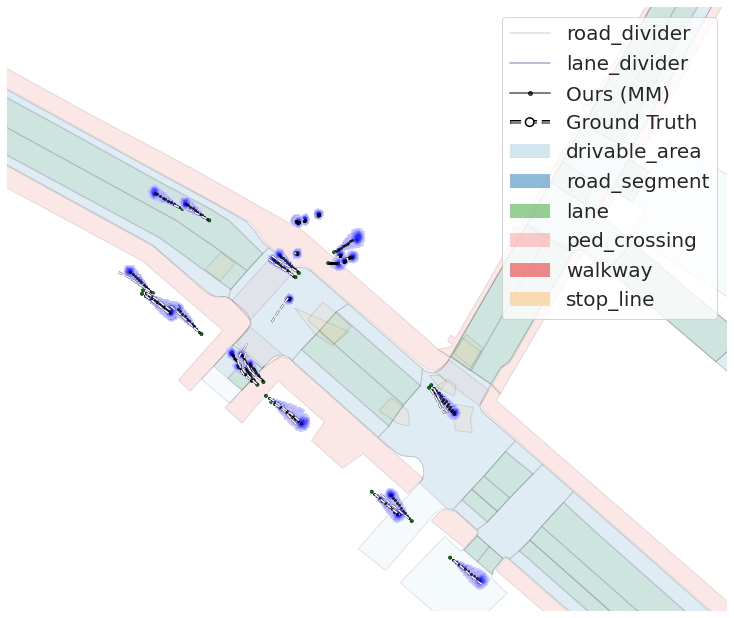

In [17]:
ph = 10
with torch.no_grad():
    timestep = np.array([12])
    predictions = eval_stg.predict(scene,
                                   timestep,
                                   ph,
                                   num_samples=500)

    predictions_mm = eval_stg.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      z_mode=True,
                                      gmm_mode=True)
    
    x_min=580.0
    x_max=710.0
    y_min=1573.0
    y_max=1682.0

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--o', label='Ground Truth',
            linewidth=3,
            path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

    plot_vehicle_nice(ax,
                      predictions,
                      scene.dt,
                      max_hl=10,
                      ph=ph,
                      map=None, x_min=x_min-63, y_min=y_min-75)

    plot_vehicle_mm(ax,
                    predictions_mm,
                    scene.dt,
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min-63, y_min=y_min-75)

    ax.set_ylim((y_min, y_max))
    ax.set_xlim((x_min, x_max))
    leg = ax.legend(loc='upper right', fontsize=20, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    # ax.get_legend().remove()
    fig.show()
    fig.savefig('plots/qual_nuScenes_map_pos.pdf', dpi=300, bbox_inches='tight')

## Prediction without Map Encoding

In [35]:
model_dir = os.path.join(log_dir, 'models_18_Jun_2025_11_36_22_int_ee_me') 
eval_stg_nm, hyp = load_model(model_dir, eval_env, ts=10)


Loading from ./models/models_18_Jun_2025_11_36_22_int_ee_me/model_registrar-10.pt
Loaded!



/home/wonder/.pyenv/versions/3.6.15/envs/nus-process/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/home/wonder/.pyenv/versions/3.6.15/envs/nus-process/lib/python3.6/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/wonder/.pyenv/versions/3.6.15/envs/nus-process/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


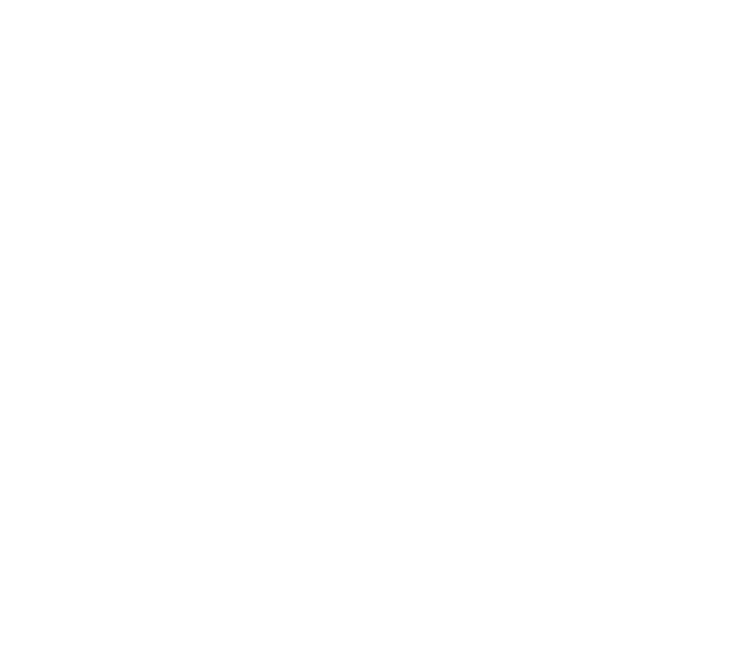

In [36]:
ph = 20
with torch.no_grad():
    timestep = np.array([2])
    predictions = eval_stg_nm.predict(scene,
                                   timestep,
                                   ph,
                                   num_samples=500)

    predictions_mm = eval_stg_nm.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      z_mode=True,
                                      gmm_mode=True)

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--o', label='Ground Truth',
            linewidth=3,
            path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

    plot_vehicle_nice(ax,
                      predictions,
                      scene.dt,
                      max_hl=10,
                      ph=ph,
                      map=None, x_min=x_min, y_min=y_min)

    plot_vehicle_mm(ax,
                    predictions_mm,
                    scene.dt,
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)

    ax.set_ylim((1385, 1435))
    ax.set_xlim((850, 900))
    leg = ax.legend(loc='upper right', fontsize=20, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    ax.get_legend().remove()
    fig.show()
    fig.savefig('plots/qual_nuScenes_no_map_pos.pdf', dpi=300, bbox_inches='tight')

## Prediction using velocity output

In [18]:
model_dir = os.path.join(log_dir, 'ee_vel') 
eval_stg_vel, hyp = load_model(model_dir, eval_env, ts=12)


Loading from ./models/ee_vel/model_registrar-12.pt
Loaded!



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


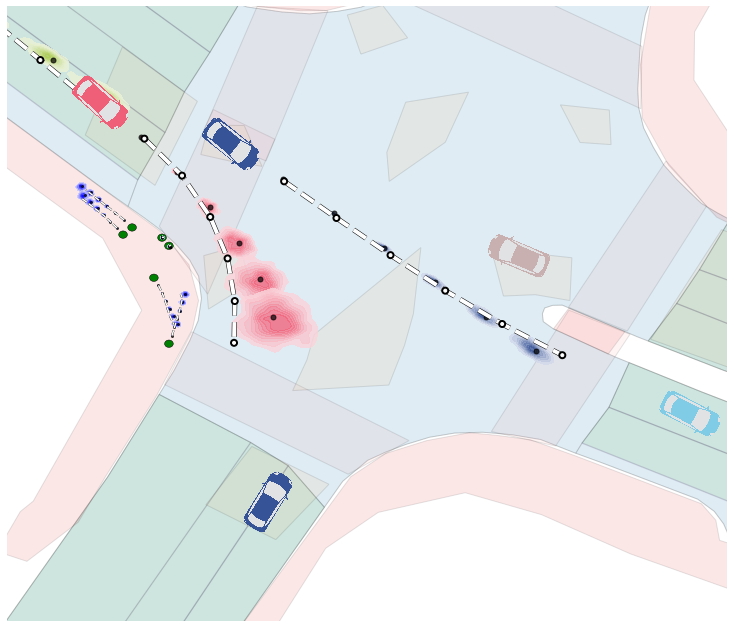

In [19]:
ph = 6
with torch.no_grad():
    timestep = np.array([2])
    predictions = eval_stg_vel.predict(scene,
                                   timestep,
                                   ph,
                                   num_samples=500)

    predictions_mm = eval_stg_vel.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      z_mode=True,
                                      gmm_mode=True)

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--o', label='Ground Truth',
            linewidth=3,
            path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

    plot_vehicle_nice(ax,
                      predictions,
                      scene.dt,
                      max_hl=10,
                      ph=ph,
                      map=None, x_min=x_min, y_min=y_min)

    plot_vehicle_mm(ax,
                    predictions_mm,
                    scene.dt,
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)

    ax.set_ylim((1385, 1435))
    ax.set_xlim((850, 900))
    leg = ax.legend(loc='upper right', fontsize=20, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    ax.get_legend().remove()
    fig.show()
    fig.savefig('plots/qual_nuScenes_no_map_vel.pdf', dpi=300, bbox_inches='tight')

## Prediction using velocity output and map

In [15]:
model_dir = os.path.join(log_dir, 'me_vel') 
eval_stg_vel_map, hyp = load_model(model_dir, eval_env, ts=12)


Loading from ./models/me_vel/model_registrar-12.pt
Loaded!



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


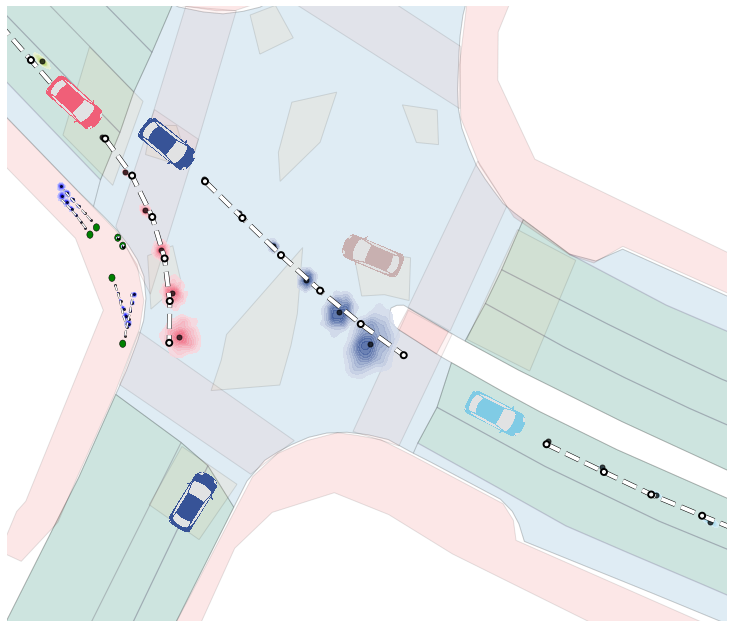

In [17]:
ph = 6
with torch.no_grad():
    timestep = np.array([2])
    predictions = eval_stg_vel_map.predict(scene,
                                   timestep,
                                   ph,
                                   num_samples=500)

    predictions_mm = eval_stg_vel_map.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      z_mode=True,
                                      gmm_mode=True)

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--o', label='Ground Truth',
            linewidth=3,
            path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

    plot_vehicle_nice(ax,
                      predictions,
                      scene.dt,
                      max_hl=10,
                      ph=ph,
                      map=None, x_min=x_min, y_min=y_min)

    plot_vehicle_mm(ax,
                    predictions_mm,
                    scene.dt,
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)

    ax.set_ylim((1385, 1435))
    ax.set_xlim((850, 900))
    leg = ax.legend(loc='upper right', fontsize=20, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    ax.get_legend().remove()
    fig.show()
    fig.savefig('plots/qual_nuScenes_map_vel.pdf', dpi=300, bbox_inches='tight')

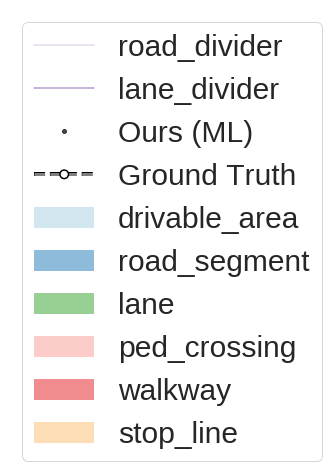

In [10]:
my_patch = (0, 0, 1, 1)
fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(1, 1), alpha=0.1, render_egoposes_range=False)
ax.plot([], [], 'ko',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (ML)')

ax.plot([],
        [],
        'w--o', label='Ground Truth',
        linewidth=3,
        path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])
leg = ax.legend(loc='upper left', fontsize=30, frameon=True)
for lh in leg.legendHandles:
    lh.set_alpha(.5)
ax.axis('off')
ax.grid('off')
fig.savefig('plots/qual_nuScenes_legend.pdf', dpi=300, bbox_inches='tight')